In [1]:
%matplotlib inline

import numpy
import scanpy.preprocessing
import scanpy.plotting
import scanpy.tools
import matplotlib.pyplot as plt



In [2]:
adata = scanpy.read_h5ad("../../Data/all_data_with_predictions.h5ad")

In [3]:
scanpy.preprocessing.log1p(adata)
scanpy.preprocessing.scale(adata)

In [4]:
cell_type_palette = {
    "ENTEROCYTE": "#507B9D",
    "MATURE_GOBLET": "#DA5855",
    "PANETH": "#F2A18E",
    "STEM": "#B6E0A0"
}

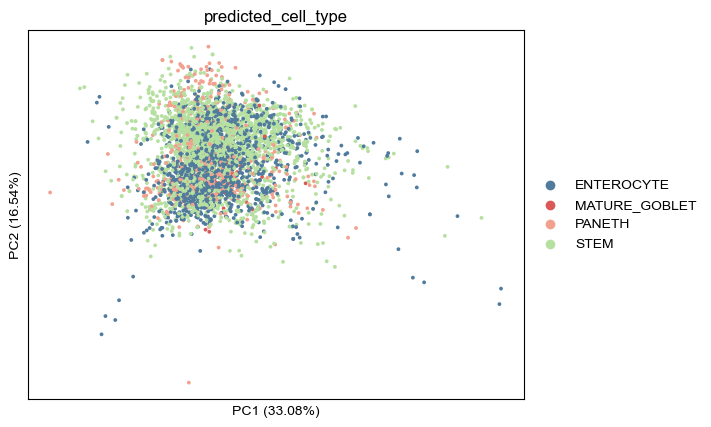

In [5]:
scanpy.tools.pca(adata, svd_solver='arpack')
scanpy.plotting.pca(adata, annotate_var_explained=True, color="predicted_cell_type", palette=cell_type_palette)

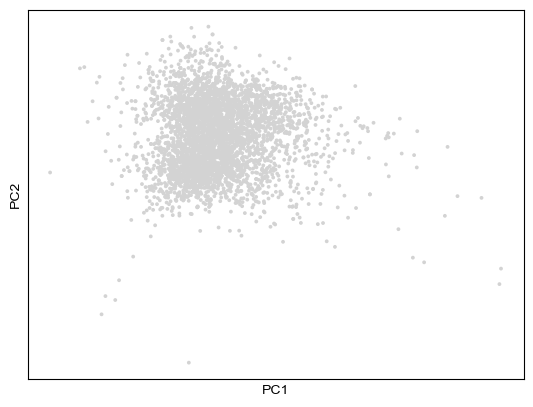

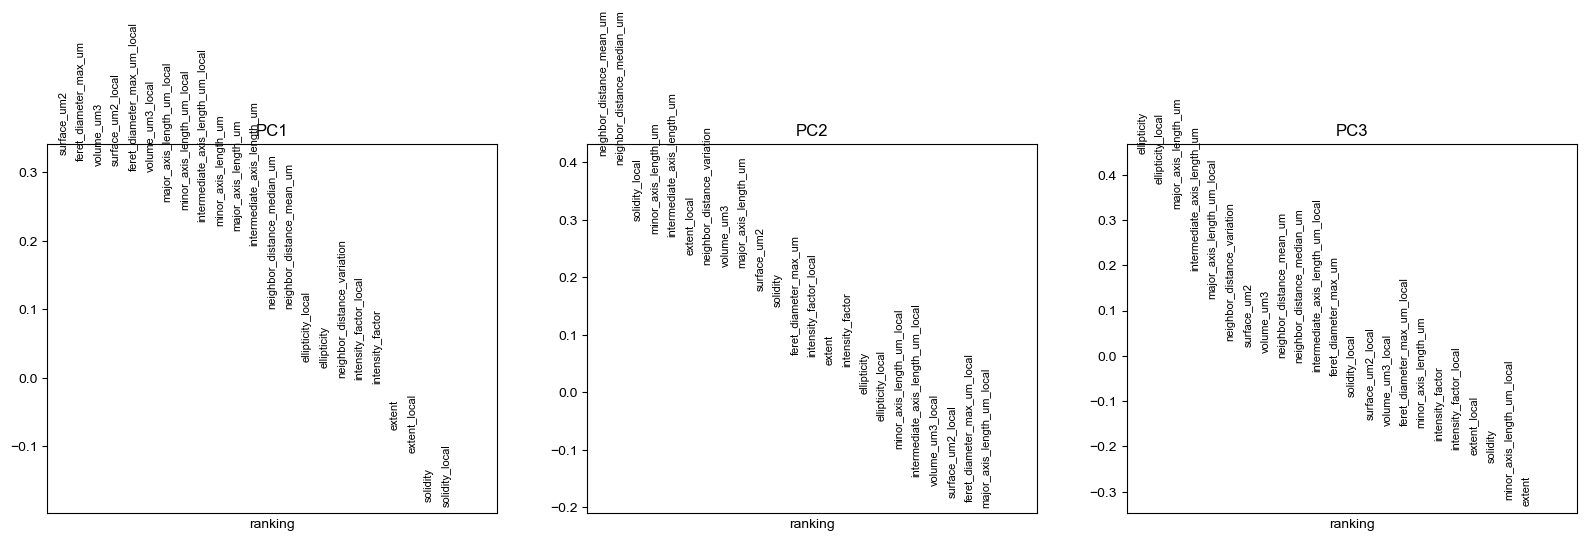

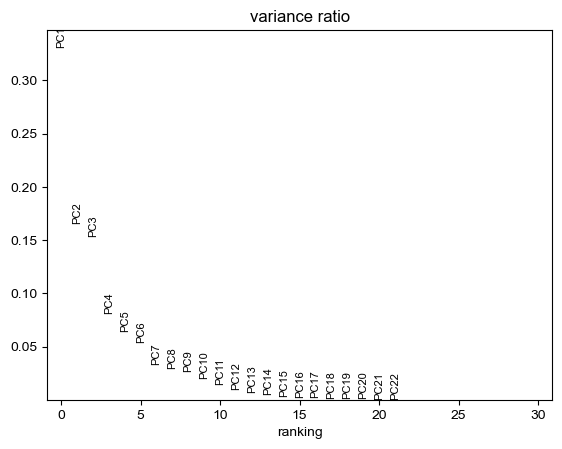

In [6]:
scanpy.plotting.pca_overview(adata)

# UMAP clustering

In [7]:
scanpy.preprocessing.neighbors(adata, n_pcs=4)
scanpy.tools.umap(adata)
scanpy.tools.leiden(adata)

C:\Users\rkok\AppData\Local\Temp\ipykernel_4908\3974073983.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  scanpy.tools.leiden(adata)


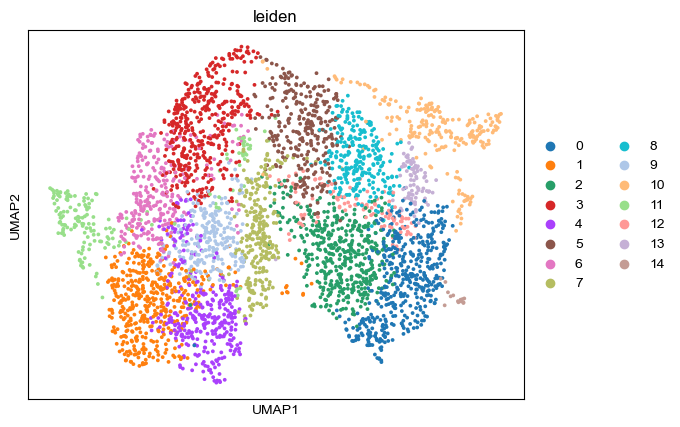

In [8]:
scanpy.plotting.umap(adata, color="leiden")

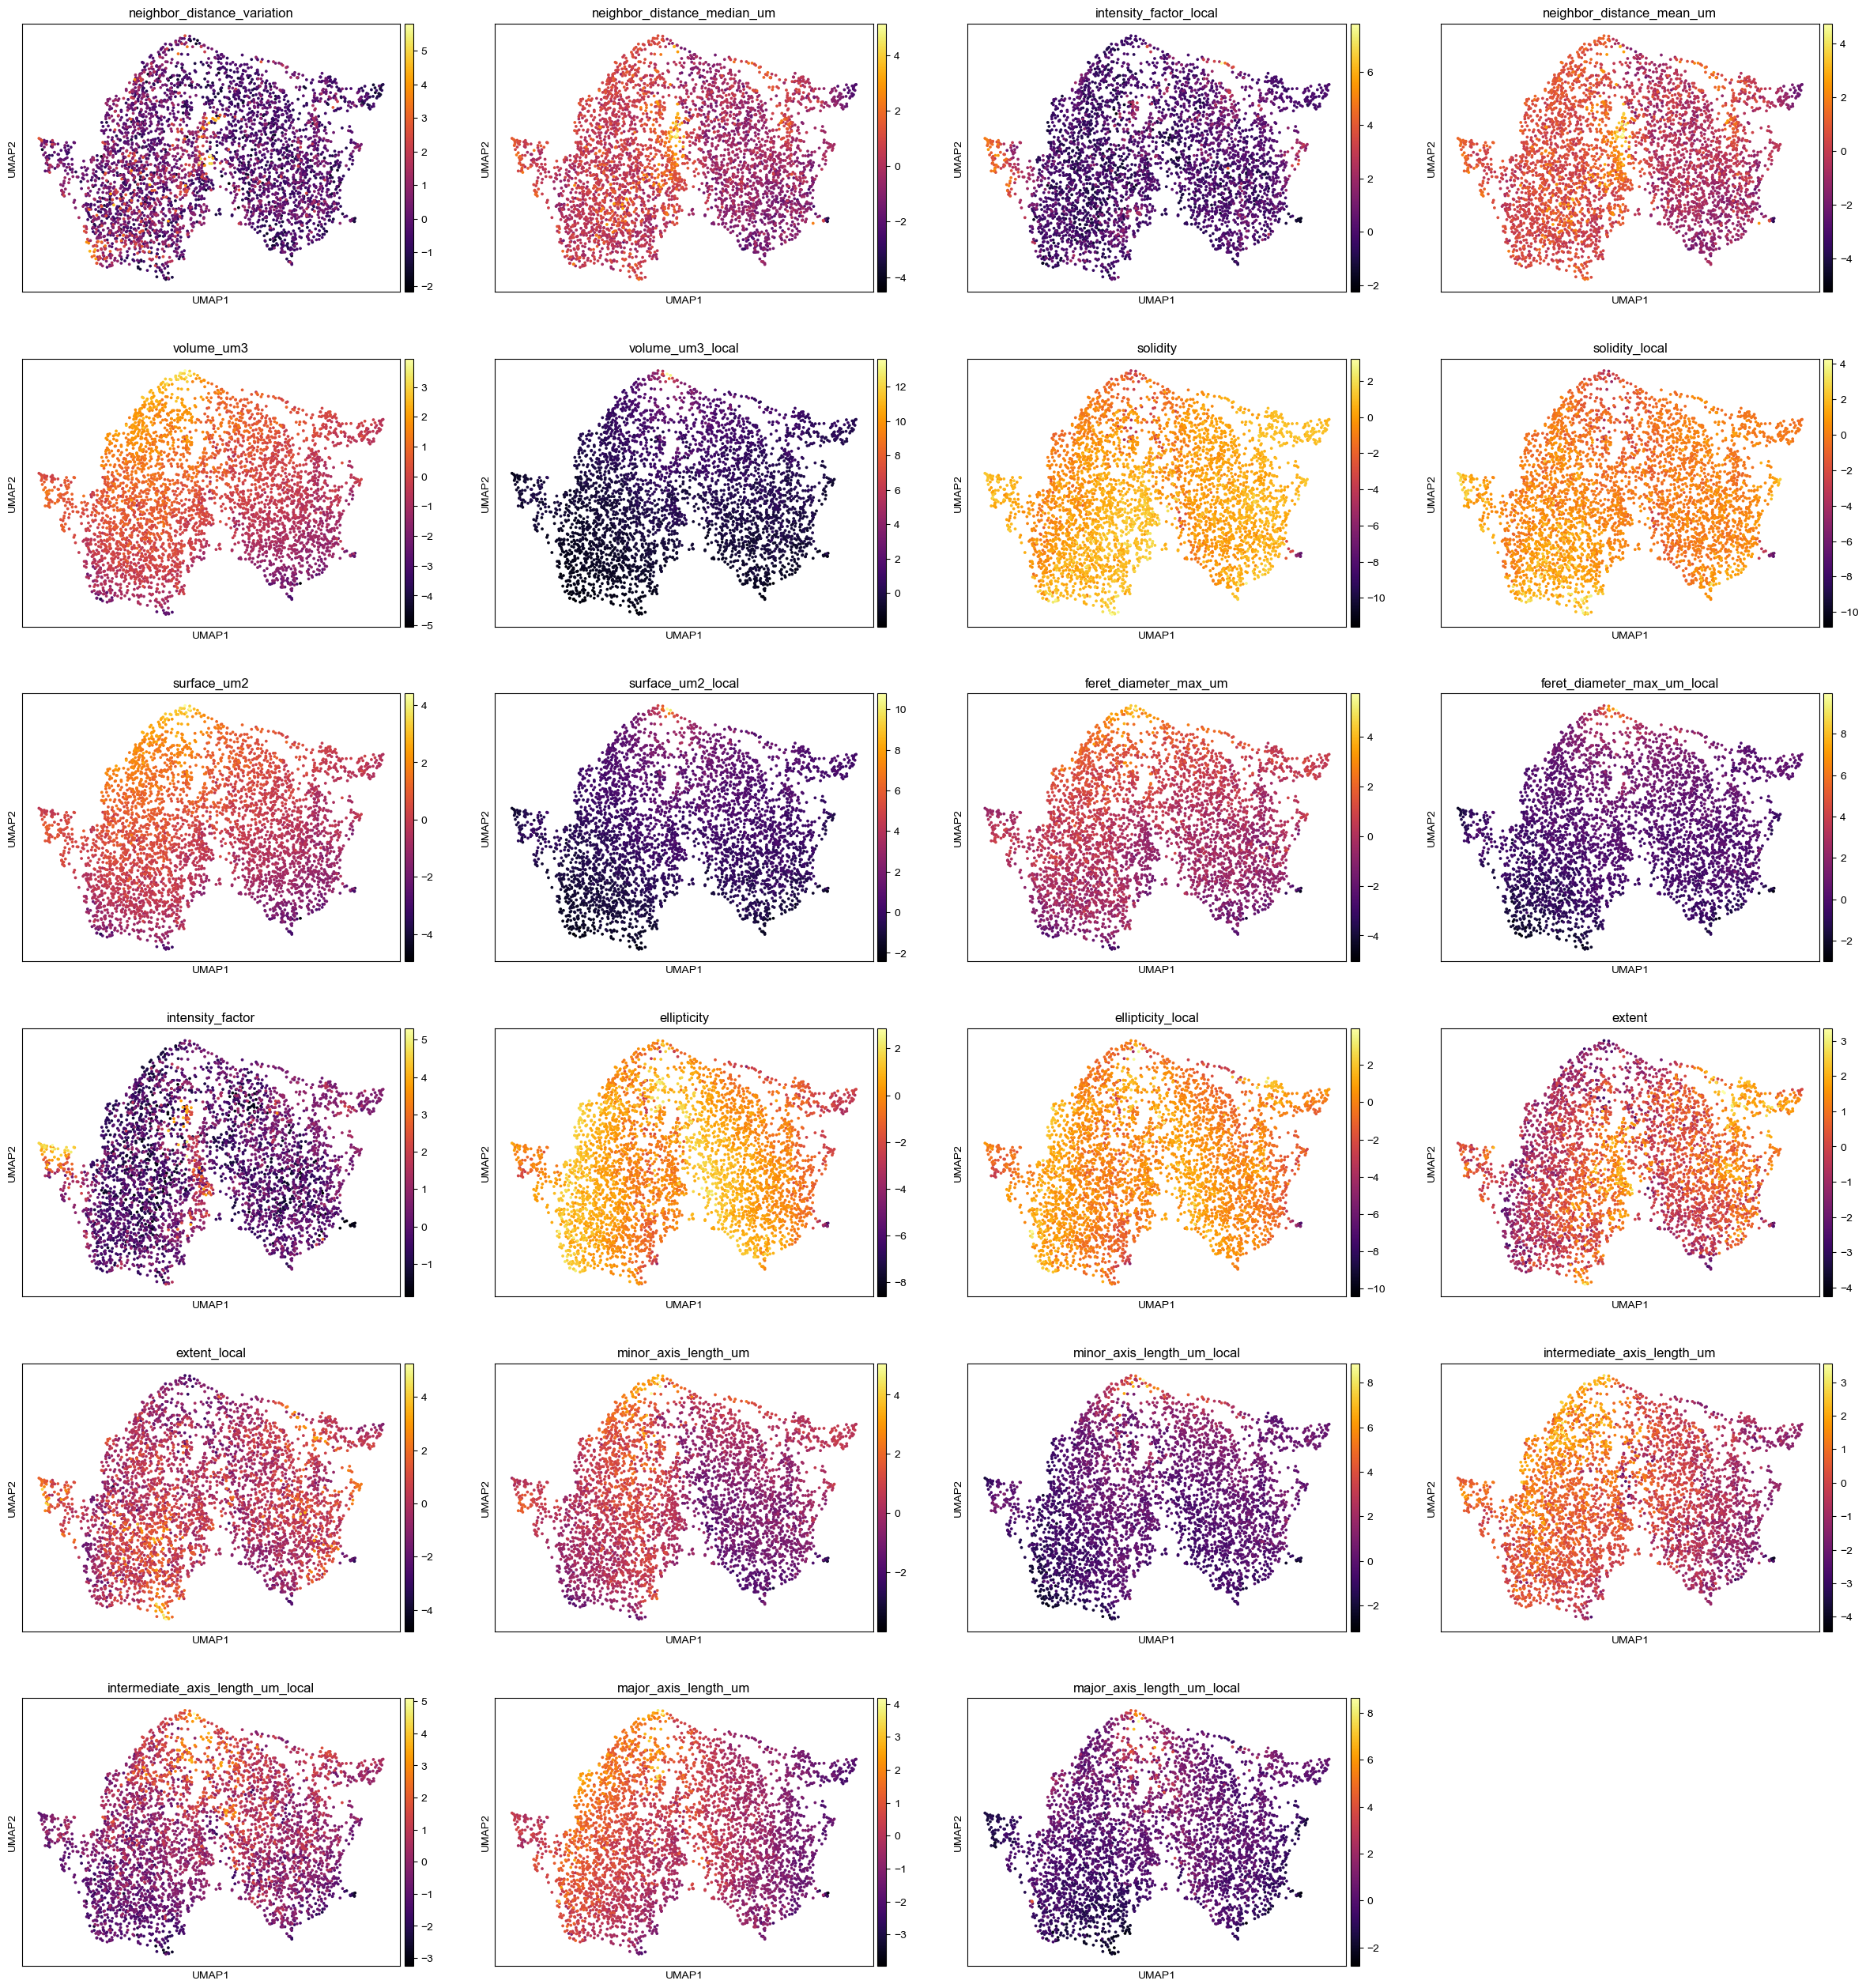

In [9]:
scanpy.plotting.umap(adata, color=adata.var_names, cmap="inferno")

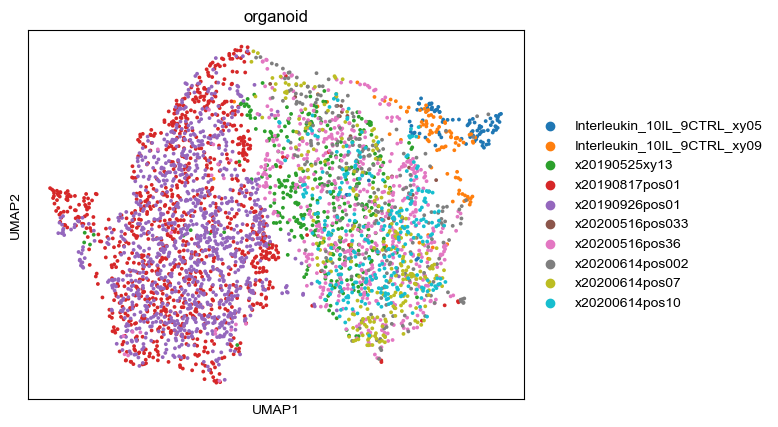

In [10]:
scanpy.plotting.umap(adata, color="organoid")

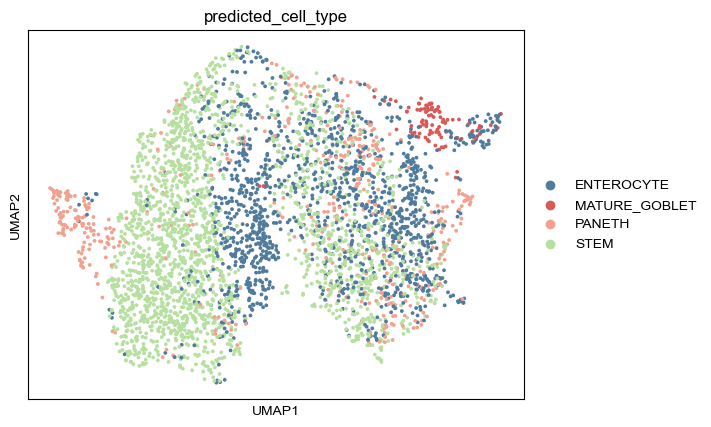

In [11]:
scanpy.plotting.umap(adata, color="predicted_cell_type")

# Checking if we can find TA cells

Idea is to find cells with a stem-to-enterocyte axis projection around 0.5, those should be the TA cells.

In [12]:
adata.obs_keys()

['cell_type',
 'cell_type_training',
 'organoid',
 'time_point',
 'predicted_cell_type',
 'predicted_ENTEROCYTE_score',
 'predicted_MATURE_GOBLET_score',
 'predicted_PANETH_score',
 'predicted_STEM_score',
 'leiden']

This is projecting every cell on the stem-to-enterocyte axis.

In [13]:
adata.obs["stem_to_enterocyte_axis"] = adata.obs["predicted_STEM_score"] + (adata.obs["predicted_PANETH_score"] + adata.obs["predicted_MATURE_GOBLET_score"]) / 2

# Set values to NaN where the cell type is not stem or enterocyte
adata.obs.loc[(adata.obs["predicted_cell_type"] != "STEM") & (adata.obs["predicted_cell_type"] != "ENTEROCYTE"), "stem_to_enterocyte_axis"] = numpy.nan

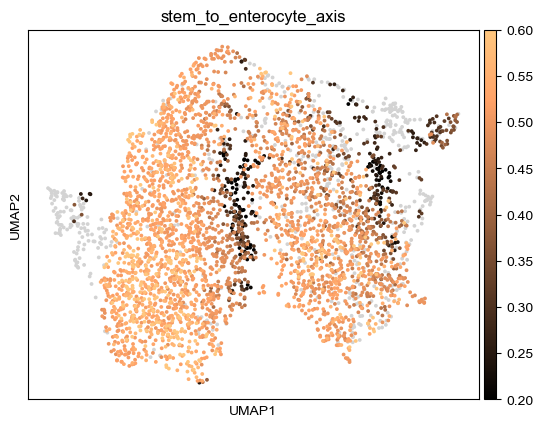

In [14]:
scanpy.plotting.umap(adata, color="stem_to_enterocyte_axis", cmap="copper", vmin=0.2, vmax=0.6)

In [15]:
# Mark cells with an stem_to_enterocyte_axis value between 0.55 and 0.45
adata.obs["is_ta"] = (adata.obs["stem_to_enterocyte_axis"] < 0.55) & (adata.obs["stem_to_enterocyte_axis"] > 0.45)

# Convert is_ta to a categorical variable
adata.obs["is_ta"] = adata.obs["is_ta"].astype("category")


adata.obs["maria_assigned_cell_type"] = "REMAINING"

# Mark everything from 0.55 and higher as stem
adata.obs.loc[adata.obs["stem_to_enterocyte_axis"] >= 0.55, "maria_assigned_cell_type"] = "STEM"

# Mark everything from 0.55 to 0.45 as TA
adata.obs.loc[(adata.obs["stem_to_enterocyte_axis"] < 0.55) & (adata.obs["stem_to_enterocyte_axis"] > 0.45), "maria_assigned_cell_type"] = "TA"

# And below 0.45 as enterocyte
adata.obs.loc[adata.obs["stem_to_enterocyte_axis"] <= 0.45, "maria_assigned_cell_type"] = "ENTEROCYTE"


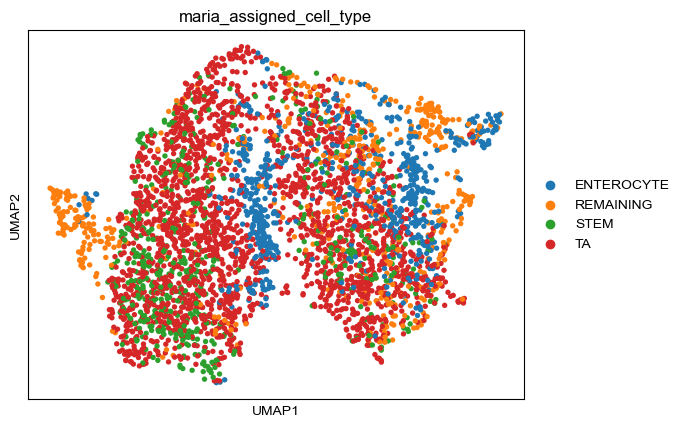

In [16]:
scanpy.plotting.umap(adata, color="maria_assigned_cell_type", s=60)

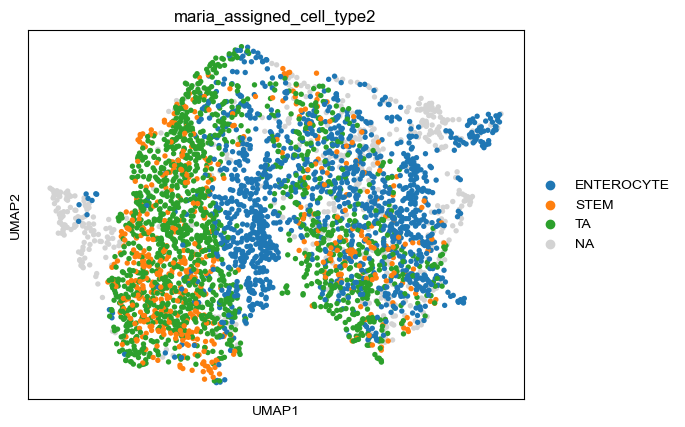

In [17]:
adata.obs["maria_assigned_cell_type"] = "REMAINING"

# Mark everything from 0.55 and higher as stem
adata.obs.loc[adata.obs["stem_to_enterocyte_axis"] >= 0.55, "maria_assigned_cell_type2"] = "STEM"

# Mark everything from 0.55 to 0.45 as TA
adata.obs.loc[(adata.obs["stem_to_enterocyte_axis"] < 0.55) & (adata.obs["stem_to_enterocyte_axis"] > 0.5), "maria_assigned_cell_type2"] = "TA"

# And below 0.45 as enterocyte
adata.obs.loc[adata.obs["stem_to_enterocyte_axis"] <= 0.5, "maria_assigned_cell_type2"] = "ENTEROCYTE"

scanpy.plotting.umap(adata, color="maria_assigned_cell_type2", s=60)

In [18]:
# Find features that are differentially expressed between TA and non-TA cells
scanpy.tools.rank_genes_groups(adata, "is_ta", method="wilcoxon")


d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


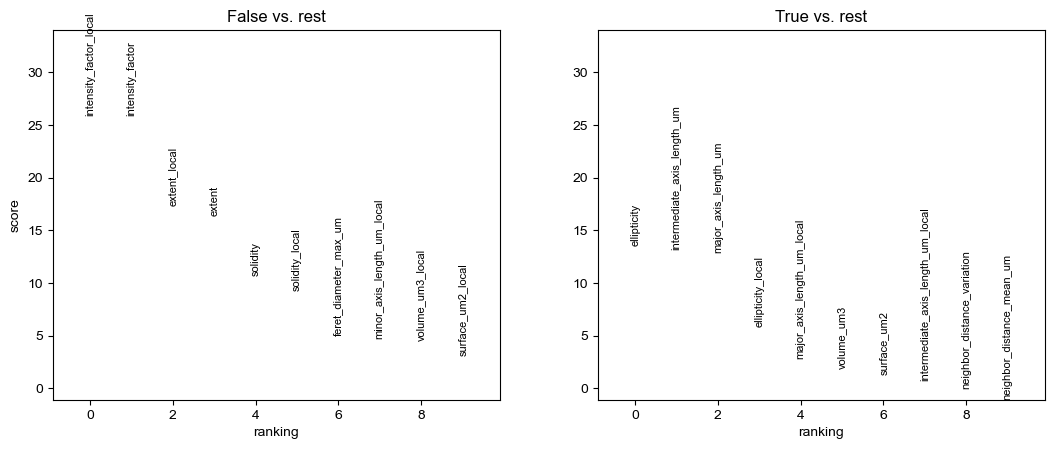

In [19]:
# Show the top 10 differentially expressed genes
scanpy.plotting.rank_genes_groups(adata, n_genes=10)